# Linear Dynamical System

> _Author:_ Giacomo Turri — [g-turri](https://github.com/g-turri)

In this example we show how Koopman theory can be used to estimate the transfer operator $\mathcal{T}$ of a simple **stochastic linear dynamical system** through the fitting of a *Principal Component Regression* (PCR) model implemented in {class}`kooplearn.models.Linear` and described in {footcite:t}`Kostic2022`. 
 
The system is of the form:

$$x_{t + 1} = A x_{t} + \xi_{t}$$

where the transfer operator is simply the transpose of $A$ and $\xi$ is Gaussian noise.

## Setup `kooplearn` + importing dependecies

In [1]:
import importlib

for module in ['kooplearn', 'ml_confs']:
    try:
        importlib.import_module(module)
    except ImportError:
      if module == 'kooplearn':
        module = 'kooplearn[full]'
      %pip install -q {module}

In [2]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import ml_confs

In [3]:
configs = ml_confs.from_dict({
    'train_samples': int(1e5),
    'test_samples': int(1e3),
})

## Data Generation
In `kooplearn`, we provide {class}`kooplearn.datasets.LinearModel` which can be used to sample data from a dynamical system defined by a matrix `A`. With this class, after having initialized the generator with matrix `A`, the variance of Gaussian noise (`noise`) and the random seed (`rng_seed`), we sample the dataset by setting the initial condition `X0` and the number of time steps `T` according to the sample sizes defined above.

In [4]:
from kooplearn.datasets import LinearModel
from scipy.linalg import eigvals

seed = 42
np.random.seed(seed)
A = np.random.randn(10,10)
A = A/np.linalg.norm(A)

A_eigs = np.sort(eigvals(A))
X0 = np.random.randn(A.shape[0])

ds_generator = LinearModel(A, noise=0.1, rng_seed=seed)
data = ds_generator.sample(initial_condition=X0, T=configs.train_samples+100+configs.test_samples)

dataset = {
    "train": data[:configs.train_samples + 1],
    "test": data[-configs.test_samples - 1:],
}

After having generated the trajectories, as already seen in the [getting started](getting_started) tutorial, we organize them into context windows using the {meth}`kooplearn.data.traj_to_contexts` method.

In [5]:
from kooplearn.data import traj_to_contexts

# From trajectories to context windows
contexts = {k: traj_to_contexts(v) for k, v in dataset.items()} # Converting the trajectories to contexts
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (100000, 2, 10): 100000 contexts of length 2 with 10 features each
Test contexts have shape (1000, 2, 10): 1000 contexts of length 2 with 10 features each


## PCR fitting

We fit the PCR models by varying the size of the training set. For each model, to measure the goodness of the estimated operator, we compute (i) the Frobenius norm of the difference between the true and the estimated linear operator, $||A-\hat{A}||_F$, and (ii) the directed Hausdorff distance (DHD) between the set of true and predicted eigenvalues.

In [6]:
from kooplearn.models import Linear
from kooplearn._src.metrics import directed_hausdorff_distance as DHD

train_stops = np.logspace(2, 5, 10).astype(int)
model = Linear(reduced_rank=False, rank=len(A_eigs), svd_solver='full')

model_eigs = []
estimator_fitting_error = []
dhd_eigs = []
for i, stop in enumerate(train_stops):
    result = {}
    model = model.fit(contexts['train'][:stop])
    model_eigs.append(model.eig()),
    estimator_fitting_error.append(np.linalg.norm(A.T - model.U @ model.U.T @ model.cov_XY)),
    dhd_eigs.append(DHD(A_eigs, model.eig())),
    
results = {
    'model_eigs': model_eigs,
    'estimator_fitting_error': estimator_fitting_error,
    'dhd_eigs': dhd_eigs
}

In the left panel, we observe that the error in transfer operator estimation decreases linearly in log scale as the number of training samples increases. The center panel shows that the eigenvalues associated with the learned operators also get better and better as the size of the training set increases. In fact, the right panel shows that the true and predicted eigenvalues are virtually the same (for $n=10^5$).

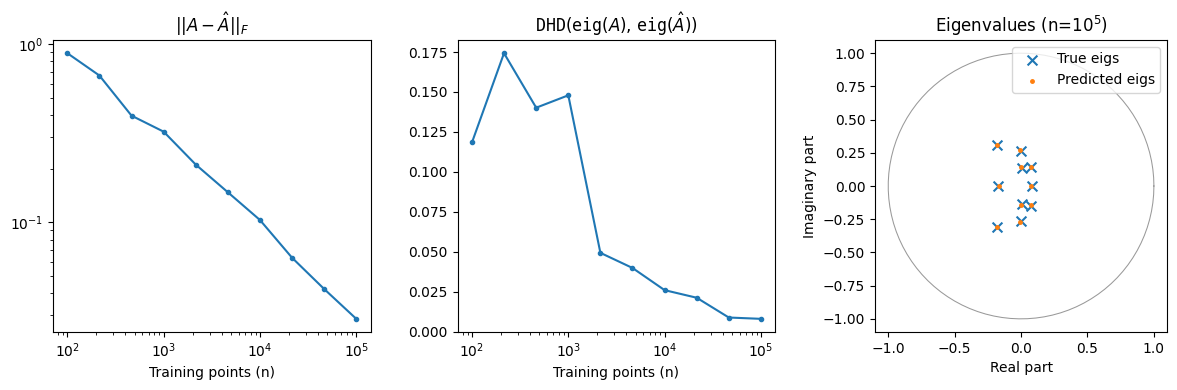

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

ax = axes[0]
ax.plot(train_stops, results['estimator_fitting_error'], '.-')
ax.set_title("$|| A-\hat{A} ||_{F}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Training points (n)')

ax = axes[1]
ax.plot(train_stops, results['dhd_eigs'],'.-')
ax.set_title("$\mathtt{DHD}$($\mathtt{eig}$($A$), $\mathtt{eig}$($\hat{A}$))")
ax.set_xscale('log')
ax.set_xlabel('Training points (n)')

ax = axes[2]
pred_eigs = np.squeeze(results['model_eigs'][-1])
ax.scatter(A_eigs.real, A_eigs.imag, label='True eigs', marker='x', s=50)
ax.scatter(pred_eigs.real, pred_eigs.imag, label='Predicted eigs', marker = '.', s=25)
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues (n=$10^5$)')
ax.legend(loc='upper right', frameon=True)
ax.set_box_aspect(1)

plt.tight_layout()
plt.show()